In [1]:
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import torch
from torch import nn

In [2]:
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1] + [nn.Flatten()]))

In [3]:
resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

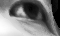

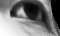

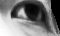

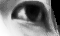

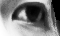

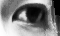

[None, None, None, None, None, None]

In [4]:
from zipfile import ZipFile
from PIL import Image
from glob import glob

image_list = []

for data in glob("data/s*/synth/000_left.zip"):

    with ZipFile(data) as archive:
        image_list.append([])
        for entry in archive.infolist():
            
            with archive.open(entry) as file:
                img = Image.open(file)
                image_list[-1].append(img)
                img.load()
                
list(map(display, image_list[0][:6]))

In [5]:
import pandas as pd
import numpy as np

gaze_list = []

for csv_file in glob("data/s*/synth/000_left.csv"):
    gaze_list.append([])
    df = pd.read_csv(csv_file, header=None)
    gaze_list[-1].append(df[[0,1,2]].values)

gaze_list = np.array(gaze_list)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
device

device(type='cuda', index=0)

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

tensor_list = []

for image_group in image_list:
    image_tensor = [transform(i) for i in image_group]
    image_tensor = torch.cat(image_tensor).float()[:,None,...]
    image_tensor = image_tensor.repeat(1, 1, 3, 1, 1)
    tensor_list.append(image_tensor)
    
image_tensor = torch.concat(tensor_list)
image_tensor.shape

torch.Size([10, 144, 3, 36, 60])

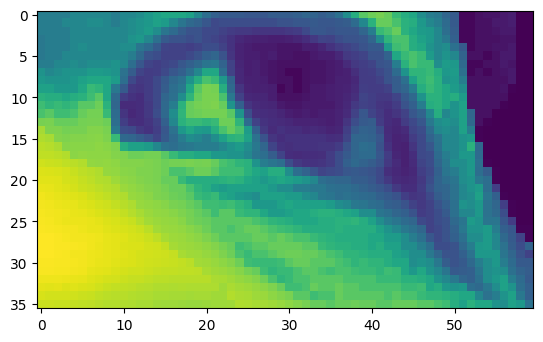

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image_tensor[0][0][0])

In [9]:
gaze_tensor = torch.concat([torch.tensor(i) for i in gaze_list]).float()
gaze_tensor.shape

torch.Size([10, 144, 3])

In [24]:
def train(backbone, criterion, optimizer, n_epochs, train_data, train_label):
    backbone.train()
    sigma2 = 1
    SIGMA_u = torch.eye(512).to(device)
    
    fixed_effects = nn.Linear(512, 3, bias=False).to(device)
    fixed_effects.train()
    
    random_effects = nn.Linear(512, 3, bias=False).to(device)
    random_effects.weight.data.fill_(0.0)
    
    h = nn.Linear(512, 3).to(device)
    h.train()
    
    I_n = torch.eye(144).to(device)
    n = 144 * 10
    N = 10
    
    for epoch in range(1, n_epochs + 1):
        
        sigma2_sum = 0
        SIGMA_u_sum = 0
        
        for i, batch in enumerate(train_data):
            ni = 144
            batch, y_i = batch.to(device), train_label[i].to(device)
            
            # E-Step
            Gamma = backbone(batch)
            y_i_random = random_effects(Gamma)
            y_i_fixed = y_i - y_i_random
            
            # Train Gamma
            loss = criterion(fixed_effects(Gamma), y_i_fixed)
            loss.backward()
            optimizer.step()
            
            V_i = Gamma @ SIGMA_u @ Gamma.T + (sigma2 * I_n)
            V_i_inv = torch.inverse(V_i)
            
            # Ûi = random_effects.weight
            random_effects.weight.data = (SIGMA_u @ Gamma.T @ V_i_inv @ (y_i - fixed_effects(Gamma))).T
            epsilon_i = y_i - fixed_effects(Gamma) - random_effects(Gamma)
            
            # M-step
            u_i = random_effects.weight.data
            sigma2_sum += epsilon_i @ epsilon_i.T + sigma2 * (ni - sigma2 * torch.trace(V_i))
            SIGMA_u_sum += u_i.T @ u_i + (SIGMA_u - SIGMA_u @ Gamma.T @ V_i_inv @ Gamma @ SIGMA_u)

        sigma2 = sigma2_sum / n
        SIGMA_u = SIGMA_u_sum / N
        
        loss = 0
        for i, batch in enumerate(train_data):
            batch, y_i = batch.to(device), train_label[i].to(device)
            Gamma = backbone(batch)
            y_i_fixed = fixed_effects(Gamma)
            y_i_random = random_effects(Gamma)
            SIGMA_e = sigma2 @ I_n
            u_i = random_effects.weight.data.T
            loss += (y_i - y_i_fixed - y_i_random).T @ torch.inverse(SIGMA_e) @ (y_i - y_i_fixed - y_i_random) + u_i.T @ torch.inverse(SIGMA_u) @ u_i + torch.det(SIGMA_e) + torch.det(SIGMA_u)
            
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch))
    return lambda x: fixed_effects(backbone(x)) + h(backbone(x))

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters())

model = train(resnet, criterion, optimizer, 10, image_tensor, gaze_tensor)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (144x3 and 144x144)